In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Blues_r')

In [2]:
df = pd.read_csv('./dataset/Assignment-1_Data.csv', sep=';')

/var/folders/l2/bknyt2k17lj2qkkxc1ls9xp40000gn/T/ipykernel_68288/1528955632.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./dataset/Assignment-1_Data.csv', sep=';')


In [3]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.000,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.000,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.000,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.000,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.000,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


## Data Cleaning

### 處理 missing values

In [5]:
df.isnull().sum().sort_values(ascending=False)

CustomerID    134041
Itemname        1455
BillNo             0
Quantity           0
Date               0
Price              0
Country            0
dtype: int64

In [6]:
df = df.dropna(subset=['Itemname'])
df['CustomerID'] = df['CustomerID'].fillna('#NA')

### create revenue column

In [7]:
df['Price'] = df['Price'].str.replace(',', '.').astype('float')
df['Revenue'] = df['Quantity'] * df['Price']

### filter out negatitive quantities

In [8]:
df = df[df['Quantity'] > 0]

## Feature Engineering

### Extrate Date Features

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%S')

In [10]:
df['dt'] = df['Date'].dt.date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_of_week
df['Hour'] = df['Date'].dt.hour

### 建立區隔/分類 segment

In [11]:
# create time-based segment
df['TimeofDay'] =pd.cut(
    df['Hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
    right=False
)

In [12]:
# create price segment
df['PriceSegment'] = pd.qcut(
    df['Price'], 
    q=4, 
    labels=['Low', 'Medium', 'High', 'Premium']
)

In [13]:
# create country group
top_countries = df['Country'].value_counts().head(5).index
df['CountryGroup'] = df['Country'].apply(lambda x: x if x in top_countries else 'Other')

## 銷售圖表

### 每日銷售量

<Axes: xlabel='dt'>

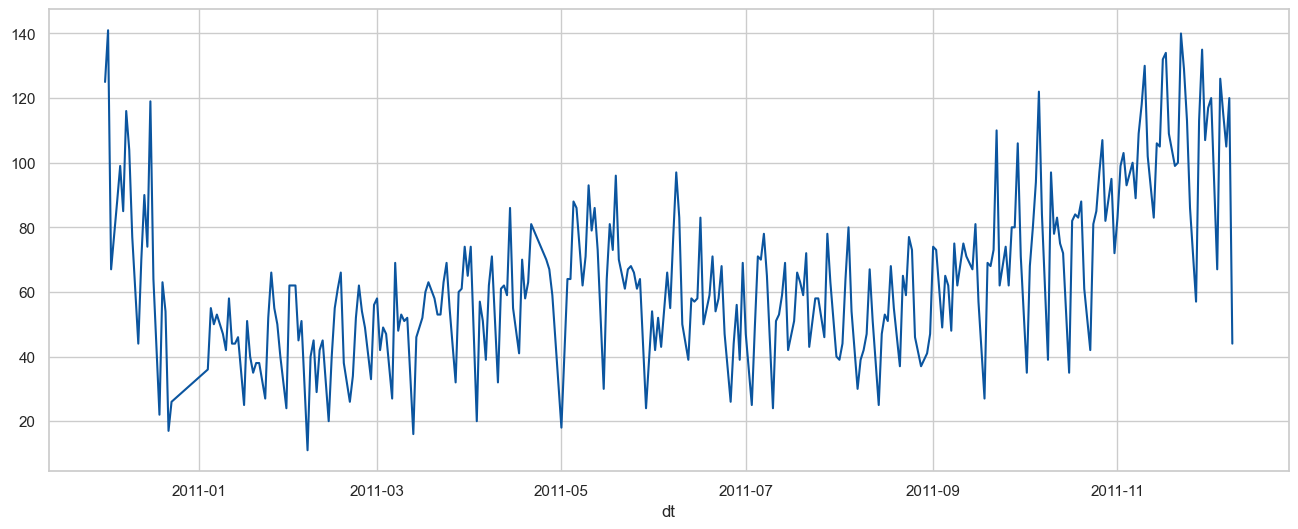

In [15]:
plt.figure(figsize=(16, 6))
df.groupby('dt')['BillNo'].nunique().plot()

### 每筆交易的平均項目數

In [16]:
df.groupby('BillNo')['Quantity'].sum().mean()

np.float64(275.73911942037796)

### weekday的營收

<Axes: xlabel='Weekday'>

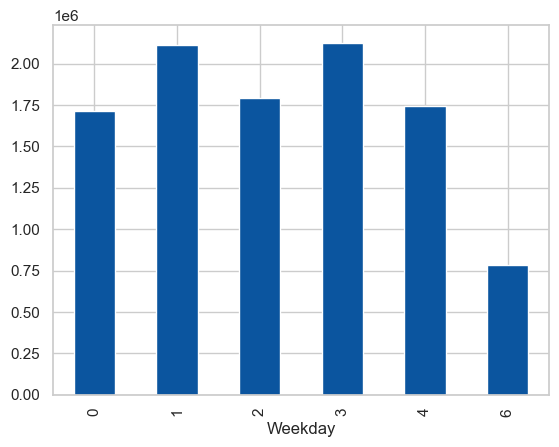

In [152]:
df.groupby('Weekday')['Revenue'].sum().plot(kind='bar')

### 銷售最好的商品

<Axes: xlabel='Itemname'>

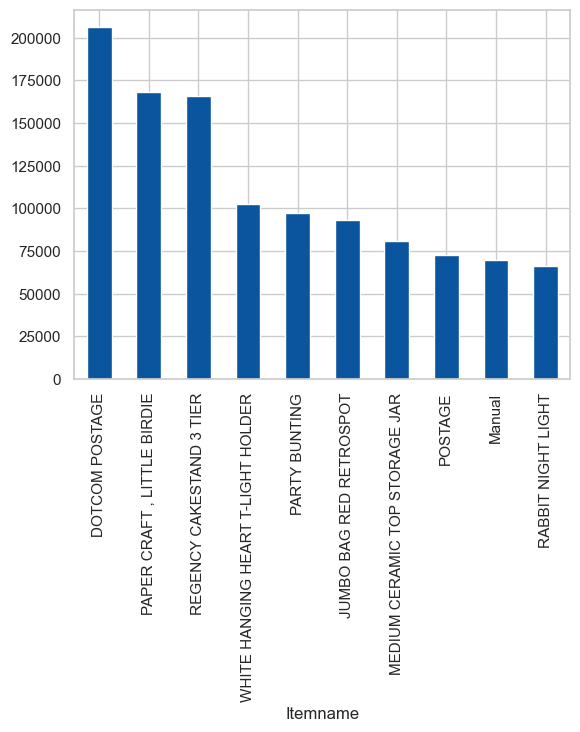

In [18]:
df.groupby('Itemname')['Revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')

## Data preparation for Association Rules

In [154]:
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country,Revenue,dt,Year,Month,day,Weekday,Hour,TimeofDay,PriceSegment,CountryGroup
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:00:26,2.550,17850.000,United Kingdom,15.300,2010-12-01,2010,12,1,2,8,Morning,High,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:00:26,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010,12,1,2,8,Morning,High,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:00:26,2.750,17850.000,United Kingdom,22.000,2010-12-01,2010,12,1,2,8,Morning,High,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:00:26,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010,12,1,2,8,Morning,High,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:00:26,3.390,17850.000,United Kingdom,20.340,2010-12-01,2010,12,1,2,8,Morning,High,United Kingdom


In [37]:
basket = df.groupby(['BillNo', 'Itemname'])['Quantity'].sum().unstack().fillna(0)
basket = basket.map(lambda x: True if x > 0 else False)
basket.head()

Itemname  *Boombox Ipod Classic  *USB Office Mirror Ball  \
BillNo                                                     
536365                    False                    False   
536366                    False                    False   
536367                    False                    False   
536368                    False                    False   
536369                    False                    False   

Itemname  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
BillNo                                                         
536365                     False                       False   
536366                     False                       False   
536367                     False                       False   
536368                     False                       False   
536369                     False                       False   

Itemname  12 DAISY PEGS IN WOOD BOX  12 EGG HOUSE PAINTED WOOD  \
BillNo                                                           
536365                        False                      False   
536366                        False                      False   
536367                        False                      False   
536368                        False                      False   
536369                        False                      False   

Itemname  12 HANGING EGGS HAND PAINTED  12 IVORY ROSE PEG PLACE SETTINGS  \
BillNo                                                                     
536365                           False                             False   
536366                           False                             False   
536367                           False                             False   
536368                           False                             False   
536369                           False                             False   

Itemname  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
BillNo                                                                     
536365                              False                          False   
536366                              False                          False   
536367                              False                          False   
536368                              False                          False   
536369                              False                          False   

Itemname  12 PENCILS SMALL TUBE RED RETROSPOT  12 PENCILS SMALL TUBE SKULL  \
BillNo                                                                       
536365                                  False                        False   
536366                                  False                        False   
536367                                  False                        False   
536368                                  False                        False   
536369                                  False                        False   

Itemname  12 PENCILS TALL TUBE POSY  12 PENCILS TALL TUBE RED RETROSPOT  \
BillNo                                                                    
536365                        False                               False   
536366                        False                               False   
536367                        False                               False   
536368                        False                               False   
536369                        False                               False   

Itemname  12 PENCILS TALL TUBE SKULLS  12 PENCILS TALL TUBE WOODLAND  \
BillNo                                                                 
536365                          False                          False   
536366                          False                          False   
536367                          False                          False   
536368                          False                          False   
536369                          False                          False   

Itemname  12 PINK HEN+C

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)

In [39]:
rulse = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

In [40]:
rulse.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(HAND WARMER OWL DESIGN),(HAND WARMER UNION JACK),0.033,0.024,0.012,0.364,14.983,1.000,0.011,1.533,0.965,0.265,0.348,0.428
1,(HAND WARMER UNION JACK),(HAND WARMER OWL DESIGN),0.024,0.033,0.012,0.493,14.983,1.000,0.011,1.906,0.956,0.265,0.475,0.428
2,(HAND WARMER UNION JACK),(HAND WARMER SCOTTY DOG DESIGN),0.024,0.028,0.011,0.449,16.255,1.000,0.010,1.764,0.962,0.266,0.433,0.422
3,(HAND WARMER SCOTTY DOG DESIGN),(HAND WARMER UNION JACK),0.028,0.024,0.011,0.394,16.255,1.000,0.010,1.611,0.965,0.266,0.379,0.422
4,(WHITE HANGING HEART T-LIGHT HOLDER),(ASSORTED COLOUR BIRD ORNAMENT),0.112,0.073,0.016,0.142,1.954,1.000,0.008,1.081,0.550,0.094,0.075,0.180
5,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.073,0.112,0.016,0.218,1.954,1.000,0.008,1.136,0.526,0.094,0.120,0.180
6,(ASSORTED COLOUR BIRD ORNAMENT),(REGENCY CAKESTAND 3 TIER),0.073,0.096,0.013,0.183,1.898,1.000,0.006,1.106,0.510,0.085,0.096,0.160
7,(REGENCY CAKESTAND 3 TIER),(ASSORTED COLOUR BIRD ORNAMENT),0.096,0.073,0.013,0.138,1.898,1.000,0.006,1.075,0.524,0.085,0.070,0.160
8,(ASSORTED COLOUR BIRD ORNAMENT),(PARTY BUNTING),0.073,0.084,0.012,0.160,1.907,1.000,0.006,1.091,0.513,0.080,0.083,0.149
9,(PARTY BUNTING),(ASSORTED COLOUR BIRD ORNAMENT),0.084,0.073,0.012,0.138,1.907,1.000,0.006,1.076,0.519,0.080,0.071,0.149


## 商品貨架管理

In [42]:
# strong reulse
strong_rules = rulse[
    (rulse['lift'] >= 3) &
    (rulse['confidence'] >= 0.3) &
    (rulse['support'] >= 0.01)
]

In [46]:
# 透過lift找出互補品
strong_rules.sort_values(['lift', 'confidence'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1615,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.011,0.012,0.010,0.952,80.674,1.000,0.010,20.752,0.998,0.823,0.952,0.905
1618,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.012,0.011,0.010,0.858,80.674,1.000,0.010,6.985,0.999,0.823,0.857,0.905
1616,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.011,0.012,0.010,0.952,80.330,1.000,0.010,20.751,0.998,0.820,0.952,0.904
1617,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.012,0.011,0.010,0.855,80.330,1.000,0.010,6.809,0.999,0.820,0.853,0.904
1601,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.012,0.012,0.011,0.931,78.554,1.000,0.011,14.390,0.999,0.868,0.931,0.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,(HANGING HEART ZINC T-LIGHT HOLDER),(JUMBO BAG RED RETROSPOT),0.030,0.105,0.010,0.337,3.226,1.000,0.007,1.351,0.711,0.081,0.260,0.217
2022,(WOODLAND CHARLOTTE BAG),(REGENCY CAKESTAND 3 TIER),0.042,0.096,0.013,0.311,3.221,1.000,0.009,1.311,0.720,0.104,0.237,0.223
974,(LUNCH BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.054,0.105,0.018,0.335,3.199,1.000,0.013,1.346,0.727,0.129,0.257,0.254
15,(LOVE BUILDING BLOCK WORD),(WHITE HANGING HEART T-LIGHT HOLDER),0.031,0.112,0.011,0.352,3.157,1.000,0.008,1.371,0.705,0.084,0.271,0.226


### 購物車分析 - 分段分析 Segmented Analysis
分別針對「早上」「晚上」分析購物車

In [62]:
time_rules = []
for time in df['TimeofDay'].unique():
    time_segment = df[df['TimeofDay'] == time]['BillNo'].unique()
    time_basket = basket.loc[time_segment]

    if len(time_basket) > 1000:
        time_frequent = fpgrowth(time_basket, min_support=0.01, use_colnames=True)
        time_rules_segment = association_rules(time_frequent, metric='lift', min_threshold=1)
        time_rules_segment['time_of_day'] = time
        time_rules.append(time_rules_segment)

In [71]:
time_rules_df = pd.concat(time_rules) # pd.concat的axis default是0，沿著維度一合併 （垂直合併 row-wise concatenation）
time_rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,time_of_day
0,(CHOCOLATE HOT WATER BOTTLE),(RED WOOLLY HOTTIE WHITE HEART.),0.038,0.021,0.010,0.270,12.659,1.000,0.009,1.340,0.957,0.209,0.254,0.376,Morning
1,(RED WOOLLY HOTTIE WHITE HEART.),(CHOCOLATE HOT WATER BOTTLE),0.021,0.038,0.010,0.483,12.659,1.000,0.009,1.859,0.941,0.209,0.462,0.376,Morning
2,(WHITE HANGING HEART T-LIGHT HOLDER),(ASSORTED COLOUR BIRD ORNAMENT),0.100,0.070,0.014,0.138,1.979,1.000,0.007,1.079,0.550,0.089,0.073,0.168,Morning
3,(ASSORTED COLOUR BIRD ORNAMENT),(WHITE HANGING HEART T-LIGHT HOLDER),0.070,0.100,0.014,0.198,1.979,1.000,0.007,1.122,0.532,0.089,0.109,0.168,Morning
4,(ASSORTED COLOUR BIRD ORNAMENT),(REGENCY CAKESTAND 3 TIER),0.070,0.093,0.011,0.164,1.761,1.000,0.005,1.085,0.465,0.076,0.078,0.144,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4793,(HAND WARMER BIRD DESIGN),(HAND WARMER RED LOVE HEART),0.033,0.023,0.010,0.311,13.347,1.000,0.009,1.417,0.956,0.222,0.294,0.374,Afternoon
4794,(HAND WARMER OWL DESIGN),(HAND WARMER RED LOVE HEART),0.037,0.023,0.013,0.350,15.015,1.000,0.012,1.502,0.969,0.273,0.334,0.453,Afternoon
4795,(HAND WARMER RED LOVE HEART),(HAND WARMER OWL DESIGN),0.023,0.037,0.013,0.556,15.015,1.000,0.012,2.169,0.956,0.273,0.539,0.453,Afternoon
4796,(HAND WARMER RED LOVE HEART),(HAND WARMER SCOTTY DOG DESIGN),0.023,0.031,0.012,0.505,16.238,1.000,0.011,1.958,0.961,0.276,0.489,0.442,Afternoon


### Customer Segment - 使用訂單資料進行分群

In [126]:
customer_df = df[df['CustomerID'] != '#NA']
customer_basket = customer_df.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().fillna(0)
customer_basket = customer_basket.map(lambda x: True if x > 0 else False)

In [131]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
basket_tfidf = tfidf.fit_transform(customer_basket).toarray()
print(basket_tfidf)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.05976602 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [133]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pca
pca = PCA(n_components=20)
basket_pca = pca.fit_transform(basket_tfidf)

# t-sne 視覺化使用
tsne = TSNE(n_components=2, random_state=3)
basket_tsne = tsne.fit_transform(basket_pca)

In [134]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_list = []
silhouette_list = []
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=3)
    model.fit(basket_pca)
    inertia_list.append(model.inertia_)

    cluster = model.predict(basket_pca)
    s_score = silhouette_score(basket_pca, cluster)
    silhouette_list.append(s_score)

Text(0.5, 1.0, 'Elbow Method')

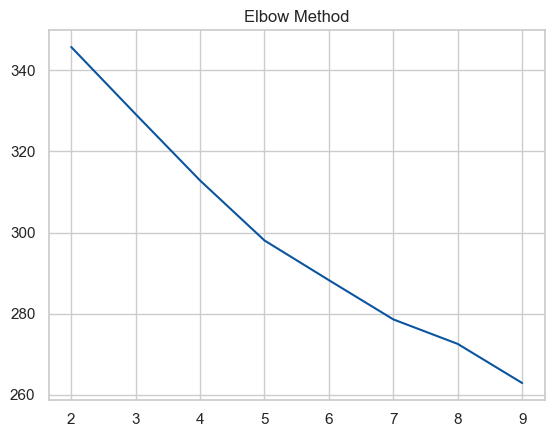

In [135]:
plt.plot(range(2, 10), inertia_list)
plt.title('Elbow Method')

Text(0.5, 1.0, 'Silhouette Score')

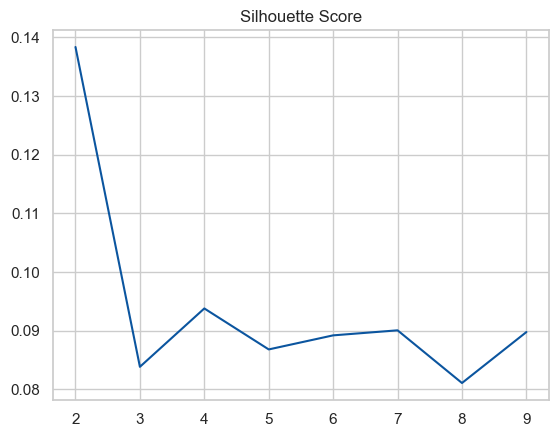

In [136]:
plt.plot(range(2, 10), silhouette_list)
plt.title('Silhouette Score')

### 選擇 k=2 作為分群

In [137]:
model = KMeans(n_clusters=2, random_state=3)
cluster = model.fit_predict(basket_pca)


In [138]:
customer_basket['Cluster'] = cluster

<Axes: >

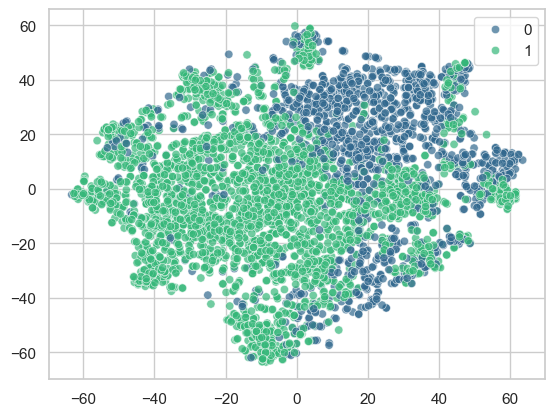

In [ ]:
sns.scatterplot(x=basket_tsne[:, 0], y=basket_tsne[:, 1], hue=cluster, palette='viridis', alpha=0.7)

### 每一群的top sales product

In [139]:
cluster_profile = customer_basket.groupby('Cluster').mean().T
cluster_profile.head()

Cluster,0,1
Itemname,,
10 COLOUR SPACEBOY PEN,0.095,0.017
12 COLOURED PARTY BALLOONS,0.056,0.010
12 DAISY PEGS IN WOOD BOX,0.024,0.004
12 EGG HOUSE PAINTED WOOD,0.014,0.006
12 HANGING EGGS HAND PAINTED,0.003,0.001


In [140]:
top_sales_by_cluster = []
for column in cluster_profile.columns:
    top_sales_by_cluster.append(cluster_profile[column].sort_values(ascending=False).head(10).index.to_list())

top_sales_by_cluster

[['JUMBO BAG RED RETROSPOT',
  'LUNCH BAG RED RETROSPOT',
  'LUNCH BAG SPACEBOY DESIGN',
  'PACK OF 72 RETROSPOT CAKE CASES',
  'LUNCH BAG CARS BLUE',
  'LUNCH BAG  BLACK SKULL.',
  'LUNCH BAG PINK POLKADOT',
  "PAPER CHAIN KIT 50'S CHRISTMAS",
  'LUNCH BAG APPLE DESIGN',
  'REGENCY CAKESTAND 3 TIER'],
 ['REGENCY CAKESTAND 3 TIER',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  'ASSORTED COLOUR BIRD ORNAMENT',
  'PARTY BUNTING',
  'HEART OF WICKER SMALL',
  'NATURAL SLATE HEART CHALKBOARD',
  'SET OF 3 CAKE TINS PANTRY DESIGN',
  'BAKING SET 9 PIECE RETROSPOT',
  'REX CASH+CARRY JUMBO SHOPPER',
  'HEART OF WICKER LARGE']]